# The breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal components as features.

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

In [2]:
import pandas as pd

# Read stuff
df = pd.read_csv('breast-cancer.data', header=None, 
                 names=['target','age', 'menopause', 'tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad', 'irradiat'])

In [3]:
from sklearn import preprocessing

# Encode to number
for col in df.columns:
    le = preprocessing.LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])

In [4]:
# Split data and target
df_data = df.drop(['target'], axis=1)
y = df.target

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(123123)

# Split train, test
df_train, df_test, y_train, y_test = train_test_split(df_data, y.values, test_size=0.2)

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(df_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
# Test score
model.score(df_test, y_test)

0.7758620689655172

In [8]:
# F1 score 
from sklearn.metrics import f1_score

f1_score(y_test, model.predict(df_test))

0.38095238095238093

<BarContainer object of 9 artists>

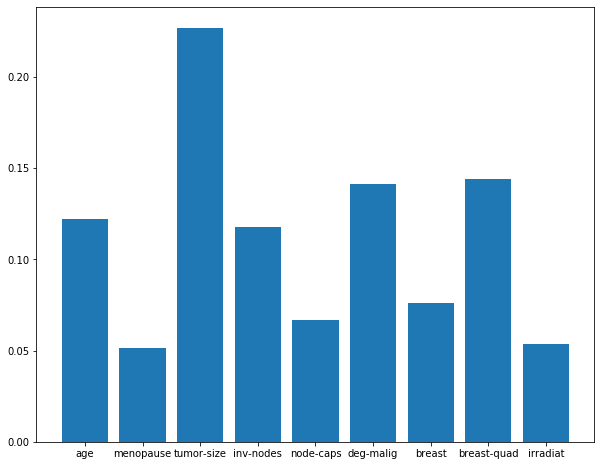

In [9]:
plt.figure(figsize=(10,8))
plt.bar(df_train.columns, model.feature_importances_)

# Quantum dude

In [158]:
# Get most important col
# 2 columns
col_num = 3
# mvp_col = [x[1] for x in sorted(zip(model.feature_importances_, df.columns), reverse=True)[:col_num]]
mvp_col = ['tumor-size', 'breast-quad', 'deg-malig']

In [159]:
# Get only MVP columns

df_train_q = df_train[mvp_col].values
df_test_q = df_test[mvp_col].values

In [148]:
from qiskit import IBMQ
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-07-07 22:07:35,564: Credentials are already in use. The existing account in the session will be replaced.


In [149]:
# Choose balance 50 sample
# 25 pos, 25 neg

np.random.seed(777)

pos_sample = 30
neg_sample = 30

pos_label = np.argwhere(y_train == 1).reshape([-1])
chosen_pos_label_idx = pos_label[np.random.permutation(len(pos_label))[:pos_sample]]

neg_label = np.argwhere(y_train == 0).reshape([-1])
chosen_neg_label_idx = neg_label[np.random.permutation(len(neg_label))[:neg_sample]]

# Construct dict to feed QSVM
training_input = {
    0: df_train_q[chosen_neg_label_idx],
    1: df_train_q[chosen_pos_label_idx]
}

test_input = {
    0: df_test_q[y_test == 0],
    1: df_test_q[y_test == 1]
}



In [161]:
def double(x):
    return np.concatenate([x, x], axis=0)

# len(double(df_train_encode[y_train == 0]))

In [162]:
training_input = {
    0: df_train_q[y_train == 0],
    1: double(df_train_q[y_train == 1])
}

test_input = {
    0: df_test_q[y_test == 0],
    1: df_test_q[y_test == 1]
}

In [154]:
training_input[1].shape

(138, 3)

In [163]:
#  Stupid Ordinal input

seed = 10598

# var_form = TwoLocal(2, ['ry'], 'cx', entanglement='circular', reps=1, insert_barriers=True)
var_form = variational_forms.RYRZ(2)

feature_map = ZZFeatureMap(feature_dimension=len(mvp_col), reps=3, entanglement='linear')

qsvm = VQC(COBYLA(100), feature_map, var_form, training_input)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


result = qsvm.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
            The <class 'qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  # Remove the CWD from sys.path while we load stuff.
2020-07-07 22:18:42,519:qiskit.aqua.quantum_instance:INFO: 
Qiskit Te

2020-07-07 22:23:18,859:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6629370447174501
2020-07-07 22:23:24,093:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6625903176272679
2020-07-07 22:23:29,101:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6657162554698203
2020-07-07 22:23:34,034:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6599694467345384
2020-07-07 22:23:39,222:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6600240436289604
2020-07-07 22:23:44,612:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.661196341431465
2020-07-07 22:23:49,818:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6623693766679829
2020-07-07 22:23:54,853:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6632301287052467
2020-07-07 22:23:59,813:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch 

In [165]:
y_pred = qsvm.predict(df_test_q)[1]


# F1 score
np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-07 22:29:20,636:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.39655172413793105, 0.25531914893617014)

In [101]:
# Save model

qsvm.save_model('VQC_50train_ordinal_3_best')

## Encode 3bits to 1qubit
So from $b_1b_2b_3\Rightarrow(\theta,\varphi)\ ; b_i\in\{-1,1\} $

In [188]:
df_q = df[mvp_col]

df_q.head()

,tumor-size,breast-quad,deg-malig
0,5,2,2
1,3,5,1
2,3,2,1
3,2,3,1
4,0,4,1


In [168]:
df_q = df[mvp_col]

data = []

for col_name in df_q.columns:
    num_cat = len(np.unique(df_q[col_name]))
    num_bit = int(np.ceil(np.log2(num_cat)))
    
    print(num_cat, num_bit)
    
    # Padding to x3 
    if num_bit % 3 != 0:
        num_bit = num_bit + (3 - (num_bit % 3))
        
        
    num_qubit = num_bit // 3

    features = []
    for size in df_q[col_name]:
        # Get last num_bit digit and reverse
        # 11 --> 001  | 011 --> 110 | 100
        
        all_b_st = f"{size:010b}"[-num_bit:][::-1]

        var_list = []
        for i in range(num_qubit):
            b_st = all_b_st[i * 3: (i+1) * 3]
            
            # b_st = b_1, b_2, b_3 = \sqrt{3}r_x, \sqrt{3}r_y, \sqrt{3}r_z

            if b_st[0] == '1':
                theta = np.arccos(1/np.sqrt(3))
            else:
                theta = np.arccos(-1/np.sqrt(3))

            if b_st[1] == '1' and b_st[2] == '1':
                varphi = np.pi / 4

            if b_st[1] == '1' and b_st[2] == '0':
                varphi = 3 * np.pi / 4

            if b_st[1] == '0' and b_st[2] == '0':
                varphi = -3 * np.pi / 4

            if b_st[1] == '0' and b_st[2] == '1':
                varphi = -np.pi / 4

            var_list += [theta, varphi]

        features.append(var_list)
#         print(size, var_list)
    data.append(np.array(features))
    
data = np.concatenate(data, axis=1)

11 4
6 3
3 2


In [169]:
# Show ordinal data vs encoded
df_q.iloc[:5],data[:5]

(   tumor-size  breast-quad  deg-malig
 0           5            2          2
 1           3            5          1
 2           3            2          1
 3           2            3          1
 4           0            4          1,
 array([[ 0.95531662, -0.78539816,  2.18627604, -2.35619449,  2.18627604,
          2.35619449,  2.18627604,  2.35619449],
        [ 0.95531662,  2.35619449,  2.18627604, -2.35619449,  0.95531662,
         -0.78539816,  0.95531662, -2.35619449],
        [ 0.95531662,  2.35619449,  2.18627604, -2.35619449,  2.18627604,
          2.35619449,  0.95531662, -2.35619449],
        [ 2.18627604,  2.35619449,  2.18627604, -2.35619449,  0.95531662,
          2.35619449,  0.95531662, -2.35619449],
        [ 2.18627604, -2.35619449,  2.18627604, -2.35619449,  2.18627604,
         -0.78539816,  0.95531662, -2.35619449]]))

In [170]:
# Features for encoding

df_train_encode, df_test_encode, y_train, y_test = train_test_split(data, y.values, test_size=0.2)

In [171]:
# Construct dict to feed QSVM

# Choose balance 50 sample

np.random.seed(777)

pos_sample = 60
neg_sample = 60

pos_label = np.argwhere(y_train == 1).reshape([-1])
chosen_pos_label_idx = pos_label[np.random.permutation(len(pos_label))[:pos_sample]]

neg_label = np.argwhere(y_train == 0).reshape([-1])
chosen_neg_label_idx = neg_label[np.random.permutation(len(neg_label))[:neg_sample]]


training_input = {
    0: df_train_encode[chosen_neg_label_idx],
    1: df_train_encode[chosen_pos_label_idx]
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}



In [172]:
training_input = {
    0: df_train_encode[y_train == 0],
    1: double(df_train_encode[y_train == 1])
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.


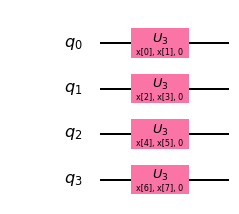

In [173]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
#     qc.u3(x2, x3, 0, 1)
#     qc.u3(x4, x5, 0, 2)
# qc.u3(x6, x7, 0, 3)

# qc.cx(0,1)
# qc.cx(2,3)
# qc.cx(1,2)

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [84]:
training_input[0].shape

(30, 6)

In [110]:
var_form

In [174]:
# 

seed = 10598

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

# print("testing success ratio: {}".format(result['testing_accuracy']))
print("preduction of datapoints:")
# print("ground truth: {}".format(map_label_to_class_name(datapoints[1], qsvm.label_to_class)))
# print("prediction:   {}".format(result['predicted_classes']))

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  """
2020-07-07 22:30:15,583:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-07 22:30:15,586:qiskit.aqua.algorithms.vq_algorithm:INFO: Start

2020-07-07 22:35:31,784:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6430254875322057
2020-07-07 22:35:38,036:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6595844651631344
2020-07-07 22:35:44,463:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6531950809966036
2020-07-07 22:35:50,826:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6468029821171531
2020-07-07 22:35:57,896:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6401265400566509
2020-07-07 22:36:04,274:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6393729832354408
2020-07-07 22:36:10,756:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6431059455039461
2020-07-07 22:36:16,998:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.636751686838709
2020-07-07 22:36:23,417:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch 

preduction of datapoints:


In [178]:
# Train acc

y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-07 22:48:39,894:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.6491228070175439, 0.4666666666666667)

In [175]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-07 22:41:33,655:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7586206896551724, 0.6500000000000001)

In [177]:
qsvm_encode.save_model('VQC_just_encode_model_3_best')

# Model 2

In [179]:
df_test_encode.shape

(58, 8)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.


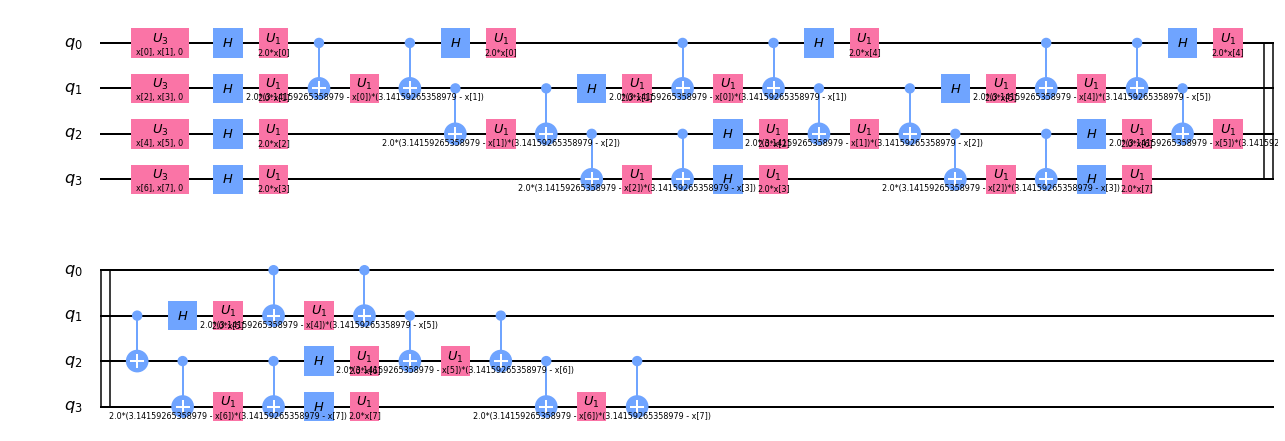

In [181]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter


num_qubits = data.shape[1] // 2
feature_map = ZZFeatureMap(feature_dimension=num_qubit, reps=2, entanglement='linear')
# ZZFeatureMap()
# def get_param(idx, zz):
#     for i, e in enumerate(zz.parameters):
#         if i == idx: return e
        
# x0 = get_param(0, feature_map) # theta_1
# x1 = get_param(1, feature_map) # varphi_1
# x2 = get_param(2, feature_map)  # theta_2

# feature_map.parameter


X = [Parameter(f'x[{i}]') for i in range(num_qubits * 2)]

var_form = variational_forms.RYRZ(num_qubits)

qc = QuantumCircuit(num_qubits)

for i in range(num_qubits):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
    

# Reassign the circuit variable
tmp1 = feature_map.assign_parameters(X[:num_qubits])
tmp2 = feature_map.assign_parameters(X[num_qubits:])

# var_form = variational_forms.RYRZ(3)

# qc.cx(0,1)
# qc.cx(2,3)
# qc.cx(1,2)

feature_map = qc + tmp1 + tmp2 
feature_map.draw('mpl')

In [76]:
!pip list | grep numpy

numpy                    1.18.5      
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [182]:
# 

seed = 10598

# qsvm_encode = QSVM(feature_map, training_input)
qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

# print("testing success ratio: {}".format(result['testing_accuracy']))
print("preduction of datapoints:")
# print("ground truth: {}".format(map_label_to_class_name(datapoints[1], qsvm.label_to_class)))
# print("prediction:   {}".format(result['predicted_classes']))

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  
2020-07-07 22:51:58,508:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-07 22:51:58,511:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting

2020-07-07 23:00:13,941:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.663191763950413
2020-07-07 23:00:23,893:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.641117345609613
2020-07-07 23:00:33,738:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6655118439260927
2020-07-07 23:00:44,311:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6358107915630264
2020-07-07 23:00:54,469:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6696797477187586
2020-07-07 23:01:04,123:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6293144482409473
2020-07-07 23:01:14,033:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.693020944915558
2020-07-07 23:01:23,838:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6302830969000237
2020-07-07 23:01:34,185:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch co

preduction of datapoints:


In [184]:
# Train acc
y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-07 23:11:42,180:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7017543859649122, 0.575)

In [183]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-07 23:08:54,715:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.603448275862069, 0.46511627906976744)

In [186]:
result

{'num_optimizer_evals': 100,
 'min_val': 0.6057697055045383,
 'opt_params': array([ 1.57894085,  2.11888745,  1.50680152,  1.36252542,  0.38717875,
        -0.4442979 , -0.41621568,  1.82778246,  3.06276716, -0.21646822,
         0.7318231 ,  0.40220313, -1.22673582,  0.09799549,  1.77436745,
         1.26494503, -0.36320079,  0.81543903, -1.9725217 , -0.04829502,
         0.61871993,  0.35634542, -0.78874664, -1.85953159, -0.28770335,
        -0.66414793,  1.74142034, -0.18194993,  1.56749658,  0.17065653,
         0.01348232,  0.1917909 ]),
 'eval_time': 1016.1901092529297,
 'eval_count': 100,
 'training_loss': 0.6057697055045383,
 'predicted_probs': array([[0.53417969, 0.46582031],
        [0.65625   , 0.34375   ],
        [0.47363281, 0.52636719],
        [0.3515625 , 0.6484375 ],
        [0.60742188, 0.39257812],
        [0.79394531, 0.20605469],
        [0.57421875, 0.42578125],
        [0.31152344, 0.68847656],
        [0.41894531, 0.58105469],
        [0.4453125 , 0.5546875 ],


In [185]:
qsvm_encode.save_model('VQC_encode_model_wt_ZZ_best_3')

In [120]:
qsvm_encode.load_model('q_encode_model_wt_ZZ.npz')

In [118]:
!ls | grep model

encode_model.npz
q_encode_model_wt_ZZ.npz
q_just_encode_model.npz
q_just_encode_model_2_best.npz


kernel matrix during the training:


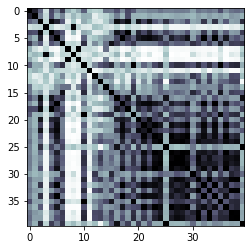

In [13]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright